# Artem Moskalev. Assignment -- 1

## Part 2: Free range practical classification

In this assignment you are asked to apply different classifiers to the dataset:

In [1]:
from sklearn.datasets import make_classification

from sklearn.model_selection import train_test_split

X_full, y_full = make_classification(n_samples=2400, n_features=20, n_informative=18,
                                     n_redundant=0, n_classes=2, random_state=2319)

You are asked to play around with these binary classification models from
the third lecture:
* logistic regression
* $k$-nearest neighbours
* Decision Tree

and check out different calssification quality measures.

You are free to use **sklearn**, **pandas**, **numpy** or any other library to the
fullest. Try to avoid writing code, and instead rely on the already implemented and
validated solutions.

Your goal is to **explore and experiment** with the dataset using these models.

### Make train / test split (2 pts.)

This step is just it: split the sample $(X, y)$ into a **train** and **test**
sample. The trick is to make the split arbitrarily random, yet **replayable**,
i.e. each separate run of your notebook **must yield exactly the same results**.

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc
from sklearn.metrics import f1_score, accuracy_score, average_precision_score, recall_score, precision_score

import itertools

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
np.random.seed(42)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.5, random_state=42)

<br/>

### Model selection

In this step you are asked to perform hyperparameter selection with $k$-fold cross
validation on the **training sample**.

Again, make sure that the folds are generated randomly, yet **replayable** as in the previous step.

Tutorial on cross validation in [sklearn](http://scikit-learn.org/stable/tutorial/statistical_inference/model_selection.html)

Basically you need to:
1. Select a range of the hyperparameter you are tuning:
    * penalty type, regularization coefficient for Logistic Regression;
    * Tree depth, number of features per split for Decision Trees;
    * the number of neighbours in $k$-NN, etc.
2. Pick a metric to evaluate with (Accuracy, precision, recall, $F_1$, or custom etc.)
3. Search for the best parameter using cross-validation and save the best model
4. rinse and repeat for another model / parameter settings.

You get extra points if you tune more than one hyperparameter.
To do this you will have to decide either
* to test all possible combinations of parameters
* or to employ a greedy optimization strategy

## Explore data

In [5]:
np.info(X_full)

class:  ndarray
shape:  (2400, 20)
strides:  (160, 8)
itemsize:  8
aligned:  True
contiguous:  True
fortran:  False
data pointer: 0x5652aff3d060
byteorder:  little
byteswap:  False
type: float64


In [6]:
np.isnan(X_full).sum()

0

In [7]:
print("# of 0's:",y_full[y_full==0].shape[0])
print("# of 1's:",y_full[y_full==1].shape[0])

# of 0's: 1199
# of 1's: 1201


It turns out that our data is pretty balanced, so the common accuracy metric or roc-auc will be okay, I guess. However, we also will try other metrics such as precision, recall, roc auc, but anyway I suggest roc-auc as the main one (because in the next task we are asked to compare models by this metric), which we also will be using for hyperparameters tuning.

In addition, since data is more or less balanced I suggest using an orinary non-stratified 5 fold cross validation.

## Model 1. Logistic regression

 - #### Step 1. Test baseline

In [8]:
logreg = LogisticRegression(random_state=42)

ROC AUC: 0.921052845875


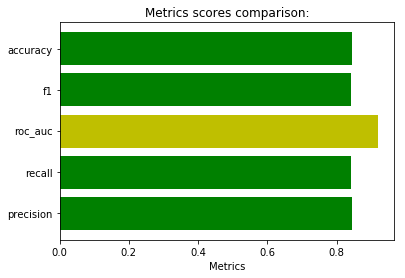

In [9]:
metrics = ('accuracy', 'f1', 'roc_auc', 'recall', 'precision')
metrics_pos = np.arange(len(metrics))
scores = list()

for each_metric in metrics:
    scores.append(cross_val_score(logreg, X_train, y_train, scoring=each_metric, cv=5).mean())

fig, ax = plt.subplots()
ax.barh(metrics_pos, scores, align='center', color='green')
ax.barh(metrics_pos[2], scores[2], align='center', color='y')
ax.set_yticks(metrics_pos)
ax.set_yticklabels(metrics)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Metrics')
ax.set_title('Metrics scores comparison:');

print('ROC AUC:',scores[2])

###### Let's build a confusion matrix, so we can see, where our classifier make its mistakes (the function plot_confusion_matrix below was taken from sklearn documentation, it's not my implementation):

In [10]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[ 0.84913793  0.15086207]
 [ 0.16129032  0.83870968]]


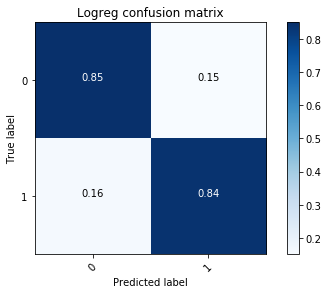

In [11]:
X_train_, X_test_, y_train_, y_test_ = train_test_split(X_train, y_train, test_size=0.4, random_state=42)
logreg.fit(X_train_,y_train_)

logreg_cm = confusion_matrix(y_true=y_test_,y_pred=logreg.predict(X_test_))
plot_confusion_matrix(logreg_cm, classes=['0','1'], normalize=True, title='Logreg confusion matrix')

###### Let's also visualize ROC-curve:

In [12]:
def get_roc_plot(model):
    test_predictions_log, test_probabilities_log = model.predict(X_test_),model.predict_proba(X_test_)[:, 1]
    training_predictions_log, training_probabilities_log = model.predict(X_train_), model.predict_proba(X_train_)[:, 1]
    
    false_positive_rates_log, true_positive_rates_log, threshold_log = roc_curve(y_test_, test_probabilities_log)
    training_false_positive_rates_log, training_true_positive_rates_log, _ = roc_curve(y_train_, training_probabilities_log)
    
    plt.plot(false_positive_rates_log, true_positive_rates_log, color='darkorange', label = 'ROC-curve on test')
    plt.plot(training_false_positive_rates_log, training_true_positive_rates_log, color='darkgreen', label = 'ROC-curve on train')
    plt.plot([0,1],[0,1], linestyle='dotted')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend()
    plt.grid();

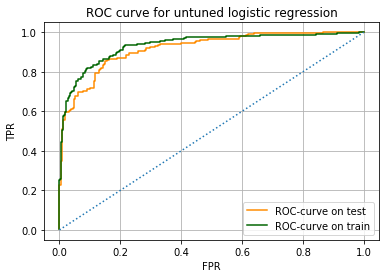

In [13]:
get_roc_plot(logreg)
plt.title('ROC curve for untuned logistic regression');

Next, I see no sense in visualizing Precision-Recall curve. Anyway, we are using neither precision nor recall as our evaluation metric, however, as I mentioned above, we are going to use a simple accuracy metrics here, so let's better switch for hyperparameters tuning

 - #### Step 2. Tune hyperparameters

In [14]:
logreg = LogisticRegression(random_state=42)

parameters = {'penalty':['l1','l2'],'C':np.arange(0.1,10,0.1)}
logreg_gs = GridSearchCV(logreg, parameters,cv=5, scoring='roc_auc')
logreg_gs.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': array([ 0.1,  0.2, ...,  9.8,  9.9])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [15]:
logreg_gs.best_score_

0.92192249292760176

In [16]:
logreg_gs.best_params_

{'C': 0.10000000000000001, 'penalty': 'l1'}

## Model 2. k-nearest neighbours

 - #### Step 1. Test baseline

In [17]:
knn = KNeighborsClassifier()

ROC AUC: 0.984426270996


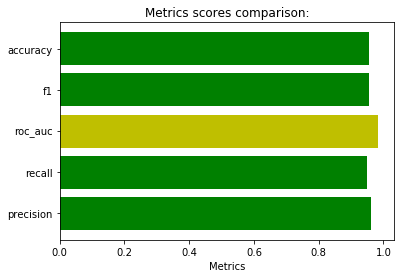

In [18]:
metrics = ('accuracy', 'f1', 'roc_auc', 'recall', 'precision')
metrics_pos = np.arange(len(metrics))
scores = list()

for each_metric in metrics:
    scores.append(cross_val_score(knn, X_train, y_train, scoring=each_metric, cv=5).mean())

fig, ax = plt.subplots()
ax.barh(metrics_pos, scores, align='center', color='green')
ax.barh(metrics_pos[2], scores[2], align='center', color='y')
ax.set_yticks(metrics_pos)
ax.set_yticklabels(metrics)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Metrics')
ax.set_title('Metrics scores comparison:');

print('ROC AUC:',scores[2])

###### Let's build a confusion matrix, so we can see, where our classifier make its mistakes:

Normalized confusion matrix
[[ 0.97844828  0.02155172]
 [ 0.07258065  0.92741935]]


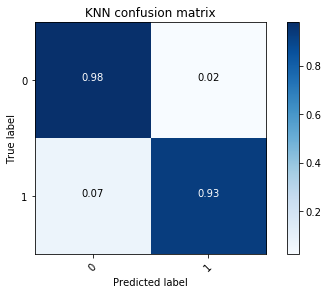

In [19]:
X_train_, X_test_, y_train_, y_test_ = train_test_split(X_train, y_train, test_size=0.4, random_state=42)
knn.fit(X_train_,y_train_)

knn_cm = confusion_matrix(y_true=y_test_,y_pred=knn.predict(X_test_))
plot_confusion_matrix(knn_cm, classes=['0','1'], normalize=True, title='KNN confusion matrix')

###### Let's visualize ROC-curve:

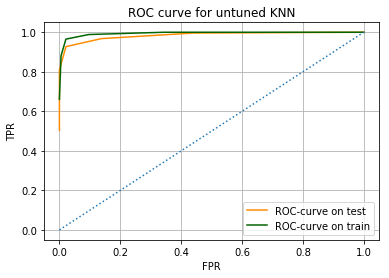

In [20]:
get_roc_plot(knn)
plt.title('ROC curve for untuned KNN');

 - #### Step 2. Tune hyperparameters

In [21]:
knn = KNeighborsClassifier()

parameters = {'n_neighbors':np.arange(1,35,1), 'p':[1,2]}
knn_gs = GridSearchCV(knn, parameters,cv=5, scoring='roc_auc')
knn_gs.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]), 'p': [1, 2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [22]:
knn_gs.best_score_

0.99105901270983987

In [23]:
knn_gs.best_params_

{'n_neighbors': 15, 'p': 2}

## Model 3. Decision Tree

 - #### Step 1. Test baseline

In [24]:
DTC = DecisionTreeClassifier(random_state=42)

In [25]:
#let's check what's the depth of our tree if we don't resctrict it
DTC.fit(X_train, y_train)
DTC.tree_.max_depth

15

ROC AUC: 0.776784522466


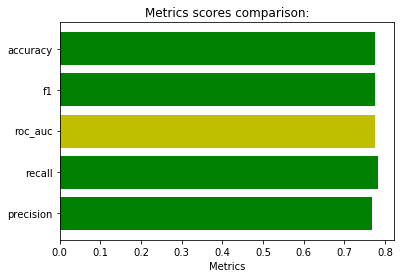

In [26]:
DTC = DecisionTreeClassifier(random_state=42)
metrics = ('accuracy', 'f1', 'roc_auc', 'recall', 'precision')
metrics_pos = np.arange(len(metrics))
scores = list()

for each_metric in metrics:
    scores.append(cross_val_score(DTC, X_train, y_train, scoring=each_metric, cv=5).mean())

fig, ax = plt.subplots()
ax.barh(metrics_pos, scores, align='center', color='green')
ax.barh(metrics_pos[2], scores[2], align='center', color='y')
ax.set_yticks(metrics_pos)
ax.set_yticklabels(metrics)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Metrics')
ax.set_title('Metrics scores comparison:');

print('ROC AUC:',scores[2])

###### Let's build a confusion matrix, so we can see, where our classifier make its mistakes:

Normalized confusion matrix
[[ 0.76293103  0.23706897]
 [ 0.24193548  0.75806452]]


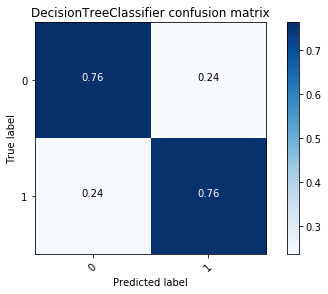

In [27]:
X_train_, X_test_, y_train_, y_test_ = train_test_split(X_train, y_train, test_size=0.4, random_state=42)
DTC.fit(X_train_,y_train_)

DTC_cm = confusion_matrix(y_true=y_test_,y_pred=DTC.predict(X_test_))
plot_confusion_matrix(DTC_cm, classes=['0','1'], normalize=True, title='DecisionTreeClassifier confusion matrix')

###### Let's visualize ROC-curve:

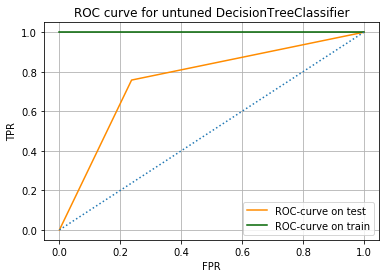

In [28]:
get_roc_plot(DTC)
plt.title('ROC curve for untuned DecisionTreeClassifier');

 - #### Step 2. Tune hyperparameters

In [29]:
DTC = DecisionTreeClassifier(random_state=42)

parameters = {'criterion':['gini','entropy'], 'splitter':['best', 'random'], 'max_depth':[11,12,13,14], 'min_samples_split':[2,3,4],'min_samples_leaf':[1,2,3]}
DTC_gs = GridSearchCV(DTC, parameters,cv=5, scoring='roc_auc')
DTC_gs.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'criterion': ['gini', 'entropy'], 'splitter': ['best', 'random'], 'max_depth': [11, 12, 13, 14], 'min_samples_split': [2, 3, 4], 'min_samples_leaf': [1, 2, 3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [30]:
DTC_gs.best_score_

0.8148888127208429

In [31]:
DTC_gs.best_params_

{'criterion': 'gini',
 'max_depth': 11,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'splitter': 'best'}

<br/>

### Compare the best models (4 pt.)

In this step you are to plot the [ROC curve](http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html) of
the best models on the **test sample**. Then using the ROC-AUC (or any
**other metric** you like) to decide which model is **the best of
the best**.

Try to be creative and not just copy the provided reference tutorials.
Don't worry if the final overall performance metric is not that high.

In [32]:
log_reg_best = LogisticRegression(**logreg_gs.best_params_)
log_reg_best.fit(X_train, y_train)

knn_best = KNeighborsClassifier(**knn_gs.best_params_)
knn_best.fit(X_train, y_train)

dtc_best = DecisionTreeClassifier(**DTC_gs.best_params_)
dtc_best.fit(X_train, y_train)

classifiers = (log_reg_best, knn_best, dtc_best)
classifiers_labels = ('Logistic regression', 'KNN', 'Decision Tree')

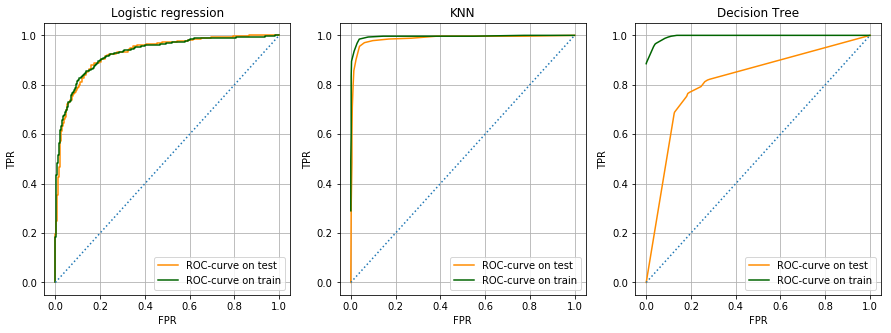

In [33]:
fig, axes = plt.subplots(1,3, figsize=(15,5))
for i,model in enumerate(classifiers):
    
    test_predictions, test_probabilities = model.predict(X_test), model.predict_proba(X_test)[:, 1]
    training_predictions, training_probabilities = model.predict(X_train), model.predict_proba(X_train)[:, 1]
    
    false_positive_rates, true_positive_rates, threshold = roc_curve(y_test, test_probabilities)
    training_false_positive_rates, training_true_positive_rates, _ = roc_curve(y_train, training_probabilities)
    
    axes[i].plot(false_positive_rates, true_positive_rates, color='darkorange', label = 'ROC-curve on test')
    axes[i].plot(training_false_positive_rates, training_true_positive_rates, color='darkgreen', label = 'ROC-curve on train')
    axes[i].plot([0,1],[0,1], linestyle='dotted')
    axes[i].legend()
    axes[i].set_xlabel('FPR')
    axes[i].set_ylabel('TPR')
    axes[i].set_title(classifiers_labels[i])
    axes[i].grid();

In [34]:
print('Logistic regression CV score on test data:',cross_val_score(log_reg_best, X_test, y_test, cv=5).mean())
print('KNN CV score on test data:',cross_val_score(knn_best, X_test, y_test, cv=5).mean())
print('Decision Tree CV score on test data:',cross_val_score(dtc_best, X_test, y_test, cv=5).mean())

Logistic regression CV score on test data: 0.85088683542
KNN CV score on test data: 0.945853443636
Decision Tree CV score on test data: 0.753298740719


###### I also suggest testing classifiers with simple accuracy metrics as well as compare others.

Accuracy: 0.85088683542


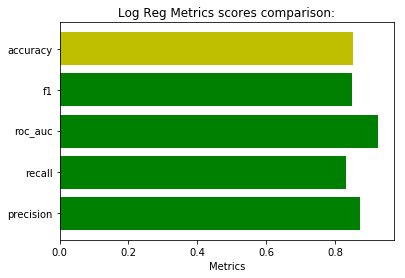

In [35]:
metrics = ('accuracy', 'f1', 'roc_auc', 'recall', 'precision')
metrics_pos = np.arange(len(metrics))
scores = list()

for each_metric in metrics:
    scores.append(cross_val_score(log_reg_best, X_test, y_test, scoring=each_metric, cv=5).mean())

fig, ax = plt.subplots()
ax.barh(metrics_pos, scores, align='center', color='green')
ax.barh(metrics_pos[0], scores[0], align='center', color='y')
ax.set_yticks(metrics_pos)
ax.set_yticklabels(metrics)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Metrics')
ax.set_title('Log Reg Metrics scores comparison:');

print('Accuracy:',scores[0])

Accuracy: 0.945853443636


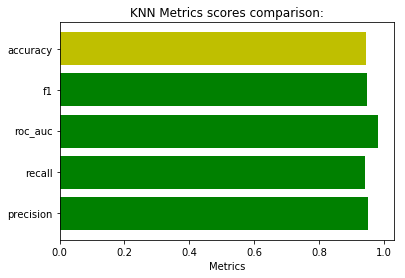

In [36]:
metrics = ('accuracy', 'f1', 'roc_auc', 'recall', 'precision')
metrics_pos = np.arange(len(metrics))
scores = list()

for each_metric in metrics:
    scores.append(cross_val_score(knn_best, X_test, y_test, scoring=each_metric, cv=5).mean())

fig, ax = plt.subplots()
ax.barh(metrics_pos, scores, align='center', color='green')
ax.barh(metrics_pos[0], scores[0], align='center', color='y')
ax.set_yticks(metrics_pos)
ax.set_yticklabels(metrics)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Metrics')
ax.set_title('KNN Metrics scores comparison:');

print('Accuracy:',scores[0])

Accuracy: 0.765833579287


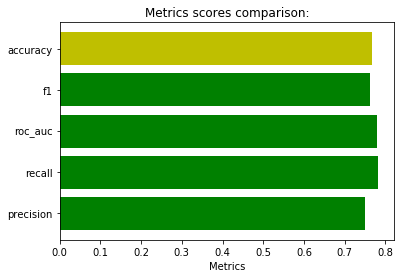

In [37]:
metrics = ('accuracy', 'f1', 'roc_auc', 'recall', 'precision')
metrics_pos = np.arange(len(metrics))
scores = list()

for each_metric in metrics:
    scores.append(cross_val_score(dtc_best, X_test, y_test, scoring=each_metric, cv=5).mean())

fig, ax = plt.subplots()
ax.barh(metrics_pos, scores, align='center', color='green')
ax.barh(metrics_pos[0], scores[0], align='center', color='y')
ax.set_yticks(metrics_pos)
ax.set_yticklabels(metrics)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Metrics')
ax.set_title('Metrics scores comparison:');

print('Accuracy:',scores[0])

###### Surprisingly, KNN turned to be the best classifier, checked on testing holdout data.